In [1]:
# !pip install numpy pandas simpleitk matplotlib 

In [3]:
# # !source setup.sh
# export nnUNet_raw_data_base="/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data"
# export nnUNet_preprocessed="/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_preprocessed"
# export RESULTS_FOLDER="/home/guest189/SPARK_Stater/mlia-project/nnUNet_trained_models"

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib
import ipywidgets as widgets
from IPython.display import display
from skimage.transform import resize
from nnunet.evaluation.evaluator import *
from nnunet.evaluation.region_based_evaluation import *
from nnunet.dataset_conversion.Task082_BraTS_2020 import * 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [3]:
TASK_NAME = 'Task500_BrainTumor'

TRAIN_IMAGES = f'/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_raw_data/{TASK_NAME}/imagesTr'
TRAIN_LABELS = f'/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_raw_data/{TASK_NAME}/labelsTr'
TEST_IMAGES = f'/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_raw_data/{TASK_NAME}/imagesTs'
TEST_LABELS = f'/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_raw_data/{TASK_NAME}/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN_BD'

train_ids = [int(fpath.split('_')[1].split('.')[0]) for fpath in os.listdir(TRAIN_IMAGES) if fpath.endswith('.nii.gz')]
train_ids.sort()

test_ids = [int(fpath.split('_')[1].split('.')[0]) for fpath in os.listdir(TEST_IMAGES) if fpath.endswith('.nii.gz')]
test_ids.sort()

print(len(train_ids), 'train', len(test_ids), 'test') 
print('file_id examples:', train_ids[:30])

id = 0
    
image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TRAIN_IMAGES, f"BraTS-GLI-{str(id).zfill(5)}-000_0000.nii.gz"), sitk.sitkFloat32)).squeeze()
label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TRAIN_LABELS, f"BraTS-GLI-{str(id).zfill(5)}-000.nii.gz"), sitk.sitkFloat32)).squeeze()

print(f'image shape is {image.shape}; label shape is {label.shape}')

1311 train 234 test
file_id examples: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image shape is (155, 240, 240); label shape is (240, 240)


In [ ]:
imgs = [nib.load(f"/scratch/guest189/BraTS2023_data/BraTS_Africa_data/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData/BraTS-SSA-00126-000/BraTS-SSA-00126-000-{m}.nii.gz").get_fdata().astype(np.float32)[:, :, 75] for m in ["t2f", "t1n", "t1c", "t2w"]]
lbl = nib.load("/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN_BD/BraTS-GLI-00001-000.nii.gz").get_fdata().astype(np.uint8)[:, :, 75]

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
titles = ["FLAIR", "T1", "T1CE", "T2", "PREDICTION"]
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(titles[i])
ax[-1].imshow(lbl, vmin=0, vmax=4)
ax[-1].axis('off')
plt.tight_layout()            
plt.show()

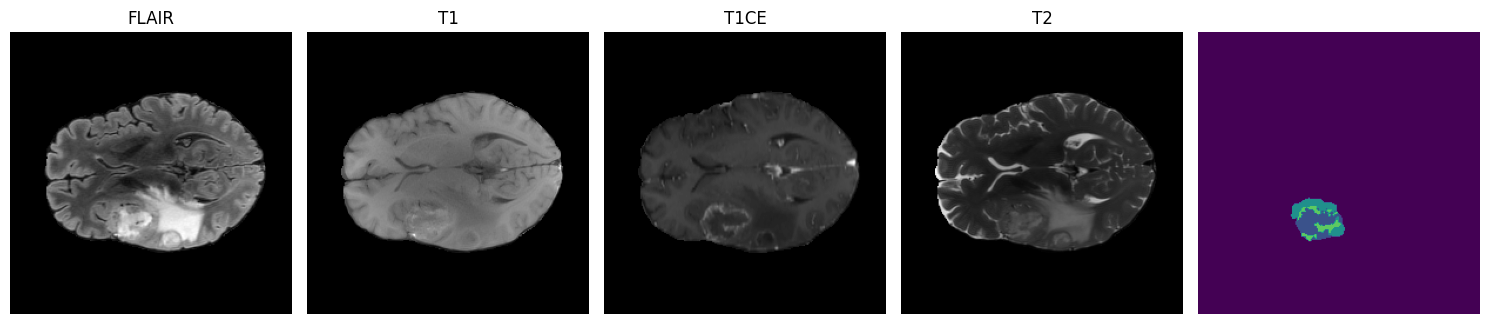

In [13]:
imgs = [nib.load(f"/scratch/guest189/BraTS2023_data/BraTS_Africa_data/ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData/BraTS-GLI-00001-000/BraTS-GLI-00001-000-{m}.nii.gz").get_fdata().astype(np.float32)[:, :, 75] for m in ["t2f", "t1n", "t1c", "t2w"]]
lbl = nib.load("/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN_BD/BraTS-GLI-00001-000.nii.gz").get_fdata().astype(np.uint8)[:, :, 75]

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
titles = ["FLAIR", "T1", "T1CE", "T2", "PREDICTION"]
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(titles[i])
ax[-1].imshow(lbl, vmin=0, vmax=4)
ax[-1].axis('off')
plt.tight_layout()            
plt.show()

BraTS-GLI-00001-000


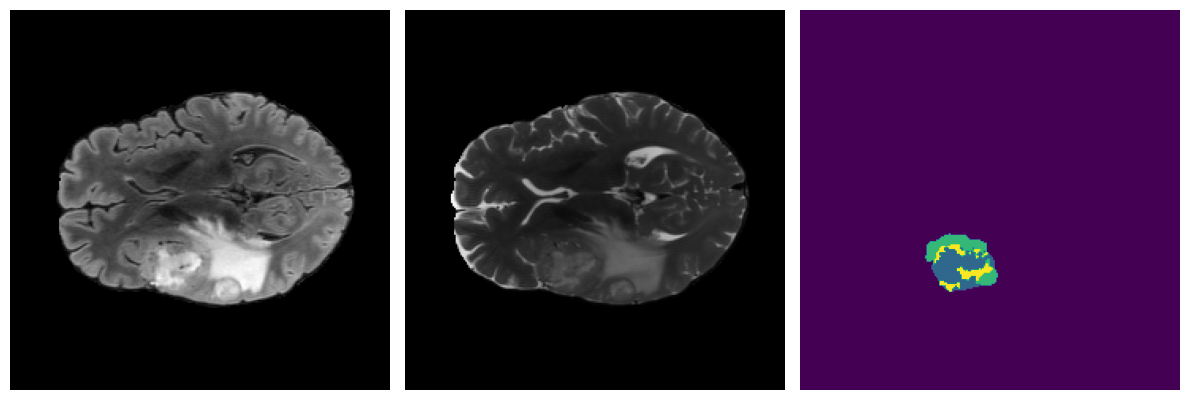

BraTS-GLI-00001-001


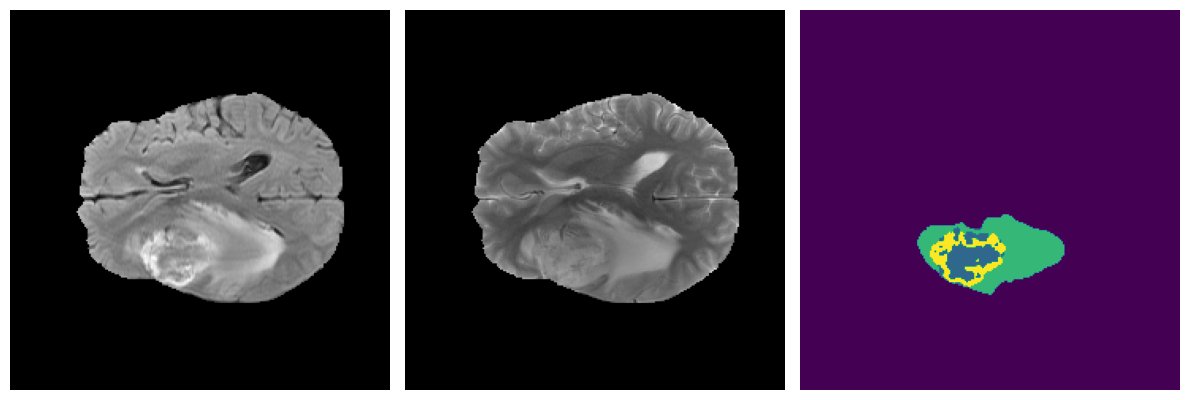

BraTS-GLI-00013-000


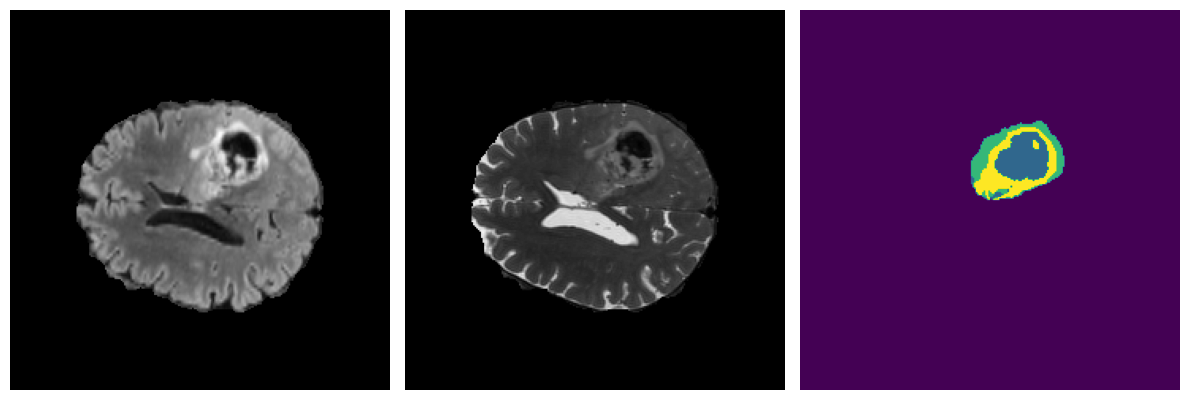

BraTS-GLI-00013-001


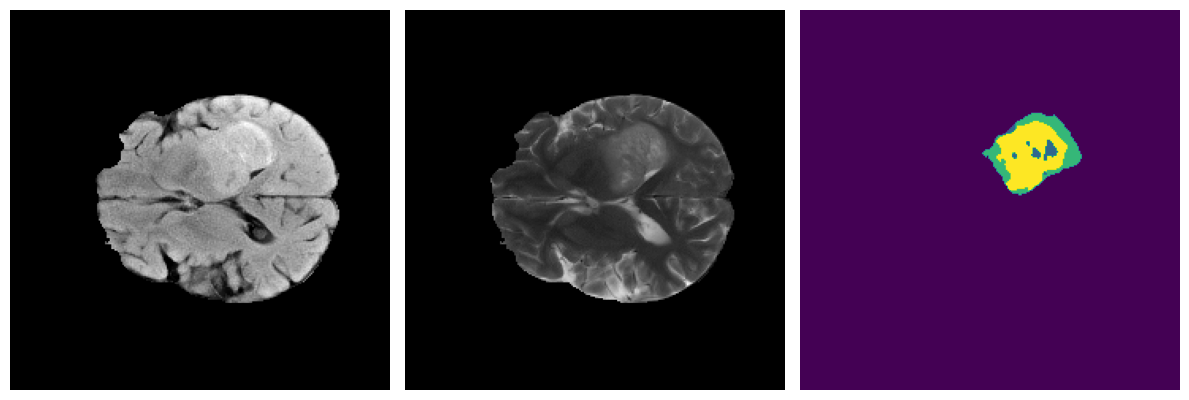

BraTS-GLI-00015-000


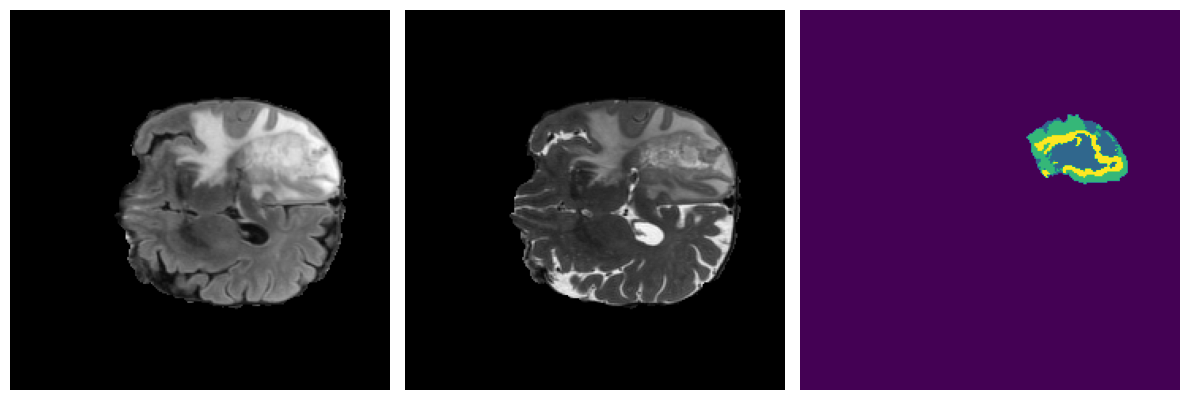

In [23]:
n, z = 5, 75
data = sorted(glob("/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN_BD/*.nii.gz"))

for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/scratch/guest189/BraTS2023_data/BraTS_Africa_data/BraTS2023_africa_val/imagesTs/{fname}.nii.gz").get_fdata().astype(np.float32)
    pred = nib.load(data[i]).get_fdata().astype(np.uint8)[:, :, z]
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

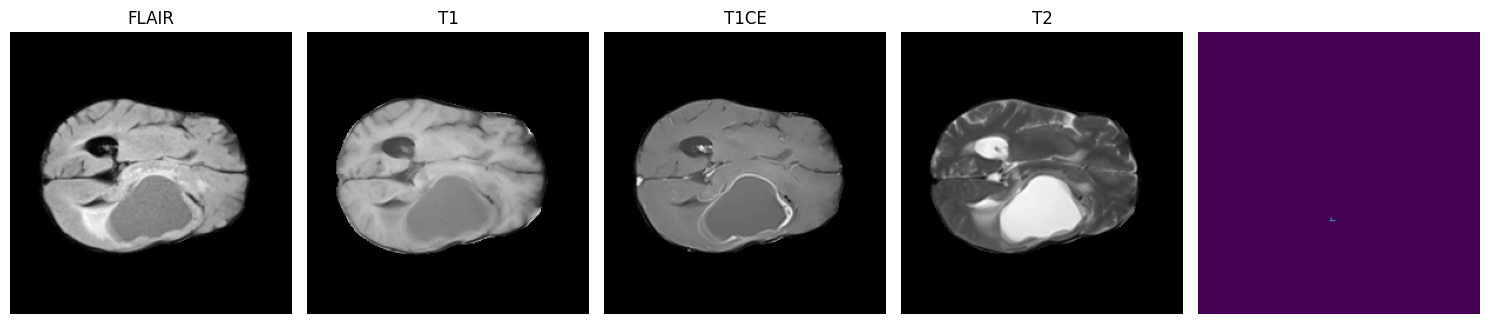

In [21]:
imgs = [nib.load(f"/scratch/guest189/BraTS2023_data/BraTS_Africa_data/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData/BraTS-SSA-00126-000/BraTS-SSA-00126-000-{m}.nii.gz").get_fdata().astype(np.float32)[:, :, 75] for m in ["t2f", "t1n", "t1c", "t2w"]]
lbl = nib.load("/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN_BD/BraTS-SSA-00126-000.nii.gz").get_fdata().astype(np.uint8)[:, :, 75]

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
titles = ["FLAIR", "T1", "T1CE", "T2", "PREDICTION"]
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(titles[i])
ax[-1].imshow(lbl, vmin=0, vmax=4)
ax[-1].axis('off')
plt.tight_layout()            
plt.show()

BraTS-SSA-00126-000


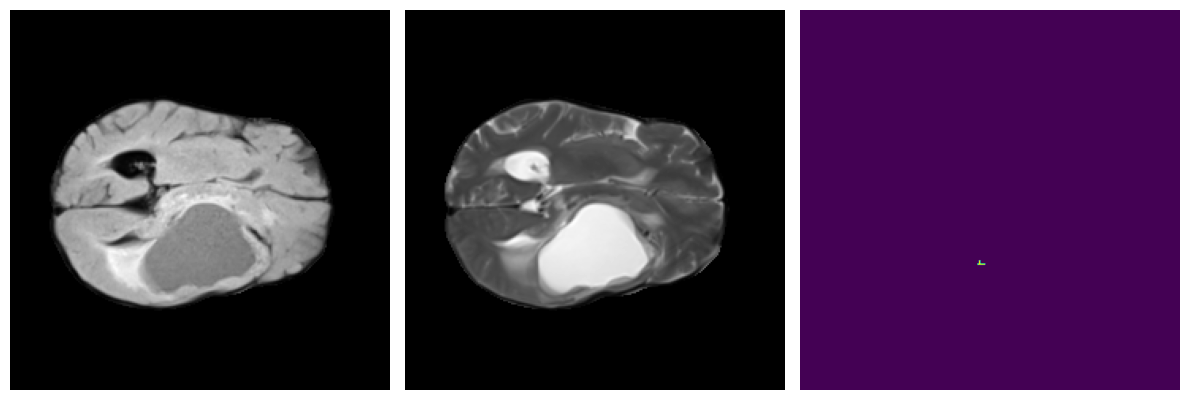

BraTS-SSA-00129-000


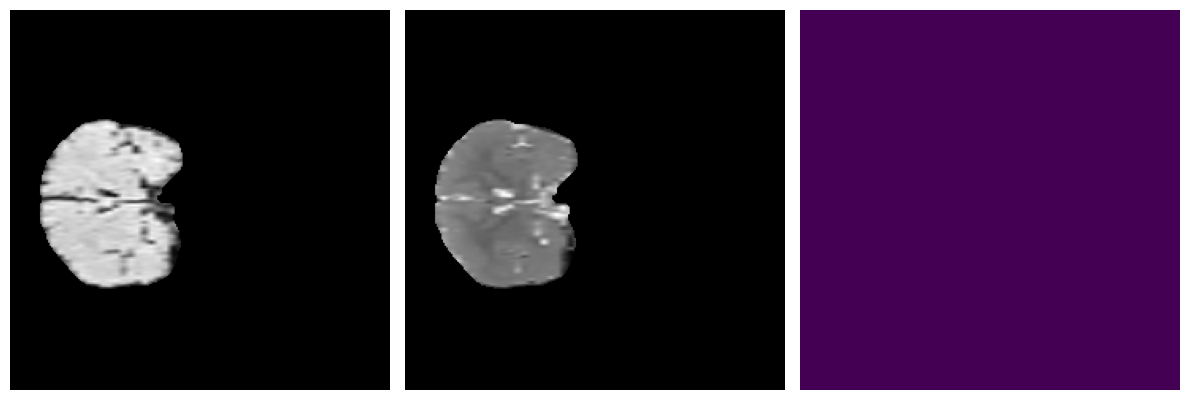

BraTS-SSA-00132-000


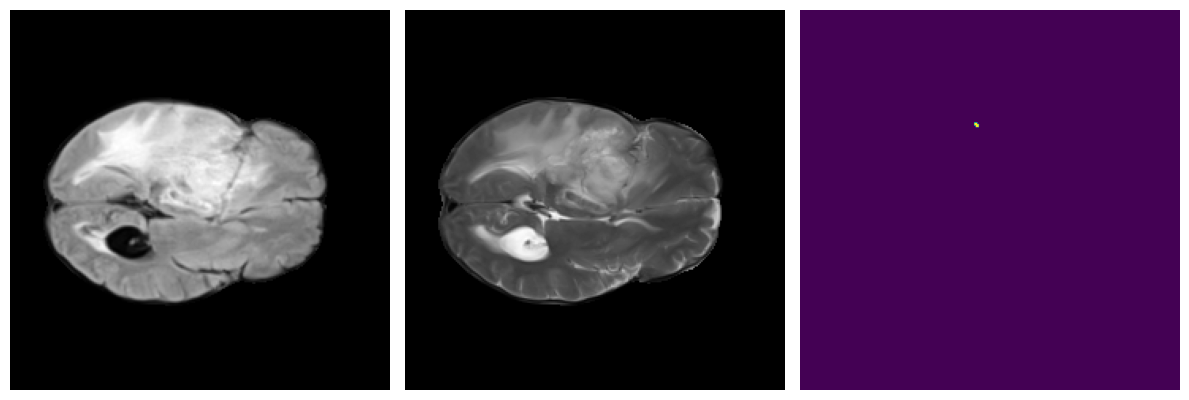

BraTS-SSA-00139-000


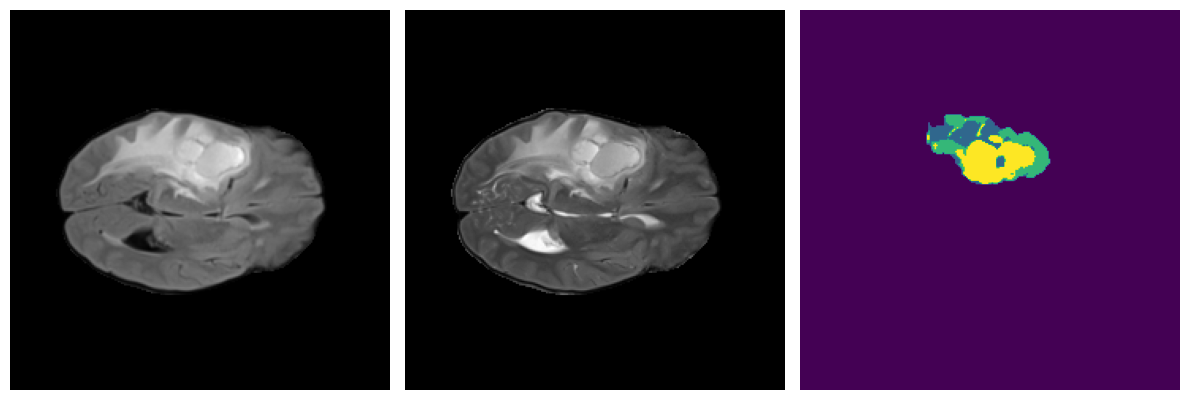

BraTS-SSA-00143-000


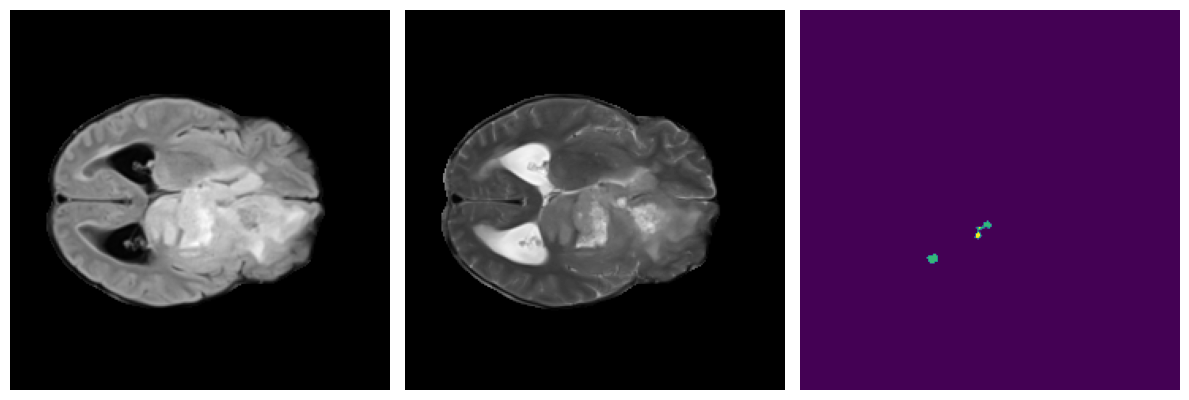

In [24]:
n, z = 5, 75
data = sorted(glob("/home/guest189/SPARK_Stater/mlia-project/nnUNet_raw_data_base/nnUNet_raw_data/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN_BD/BraTS-SSA-*.nii.gz"))

for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/scratch/guest189/BraTS2023_data/BraTS_Africa_data/BraTS2023_africa_val/imagesTs/{fname}.nii.gz").get_fdata().astype(np.float32)
    pred = nib.load(data[i]).get_fdata().astype(np.uint8)[:, :, z]
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

### Metrics

In [6]:
REF_PATH = f"nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/labelsTs"
PRED_PATH_MAIN = f"nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/predTs"

df_list = []

print('\n=========================\nTEST SET')

TRAINER_CLASS = "nnUNetTrainerV2BraTSRegions_DA4_BN_BD"

PRED_PATH = f'{PRED_PATH_MAIN}_{TRAINER_CLASS}'

evaluate_BraTS_folder(PRED_PATH, REF_PATH)

test_summary_df = pd.read_csv(f'{PRED_PATH}/results.csv')

PRED_PATH_MAIN = f"nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/predTs"
PRED_LABELS = PRED_PATH

print('\n==================\nUSING PRED_LABELS=', PRED_LABELS)
final_metrics_table = pd.DataFrame([test_summary_df.mean(axis=0), test_summary_df.std(axis=0), test_summary_df.median(axis=0), test_summary_df.quantile(axis=0, q=0.25), test_summary_df.quantile(axis=0, q=0.75)], index=['mean', 'std', 'median', '25th', '75th']) 
final_metrics_table


TEST SET

USING PRED_LABELS= nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN_BD


,dc_whole,dc_core,dc_enh,hd95_whole,hd95_core,hd95_enh
mean,0.658727,0.628755,0.819321,70.979584,71.192713,29.887745
std,0.361064,0.348218,0.277628,142.587795,142.488040,98.829734
median,0.840100,0.779300,0.894400,2.828000,3.162000,1.000000
25th,0.472875,0.457700,0.789150,1.000000,1.000000,0.000000
75th,0.903400,0.864075,1.000000,11.482500,11.782500,2.000000


### Test Set Predictions - Visualize

32088


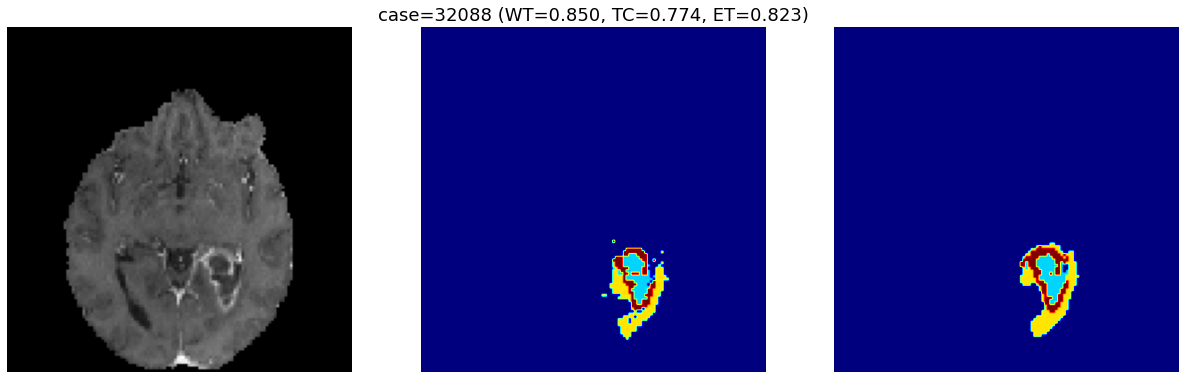

32256


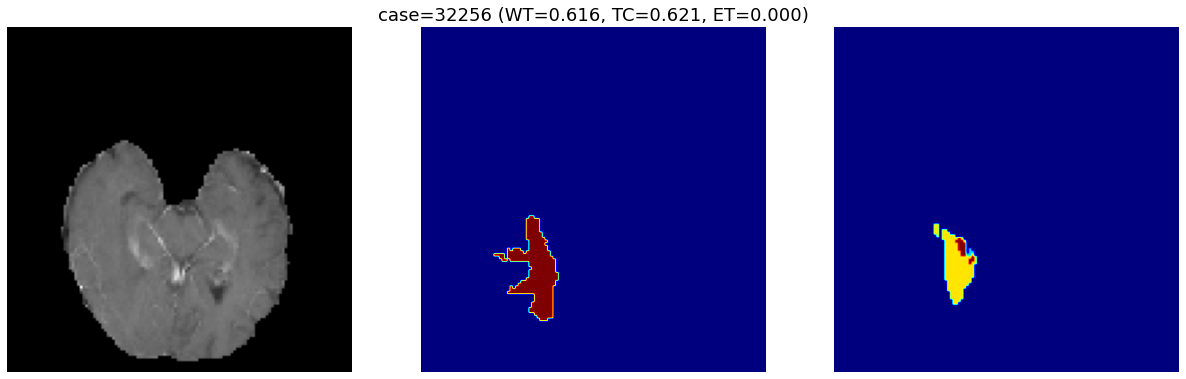

32424


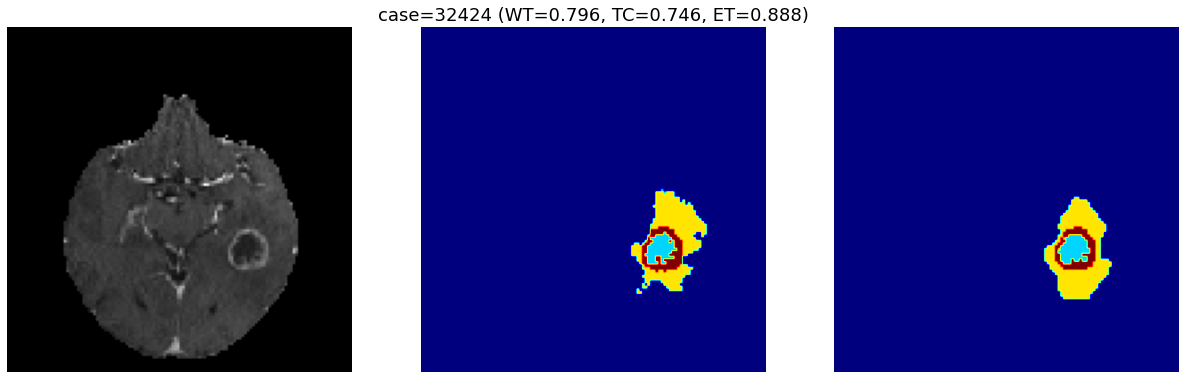

32592


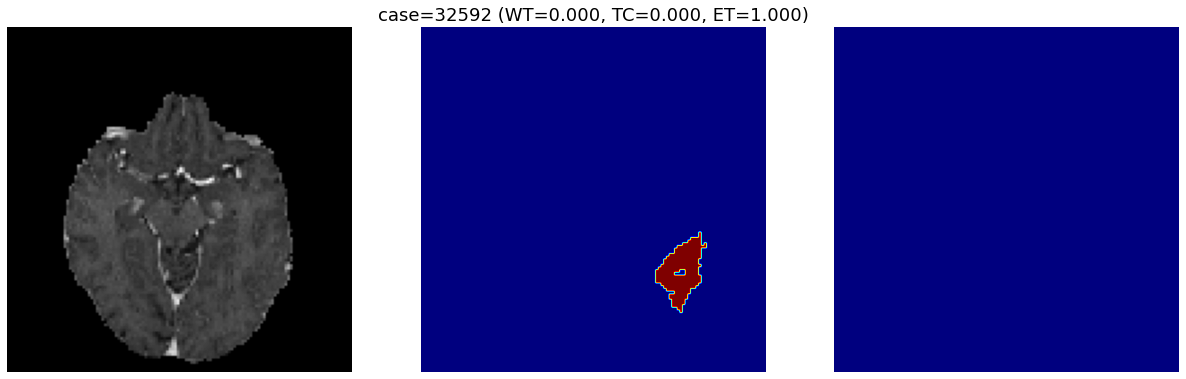

32760


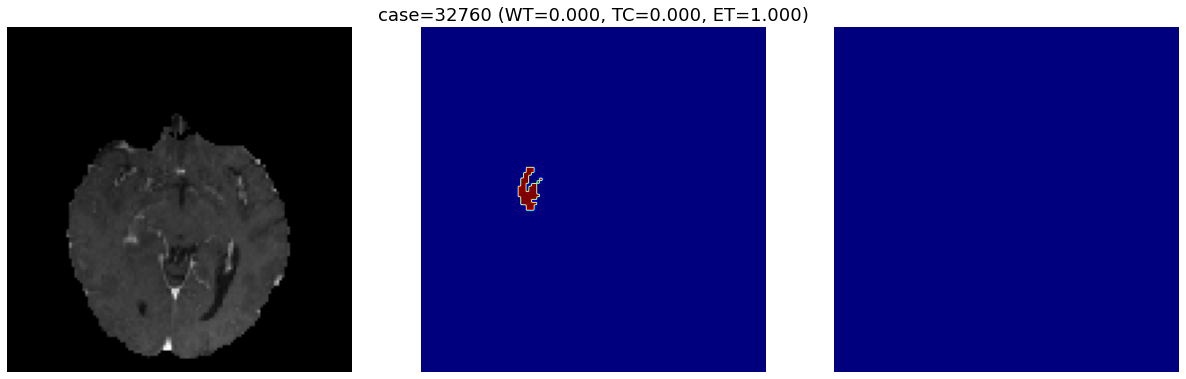

32928


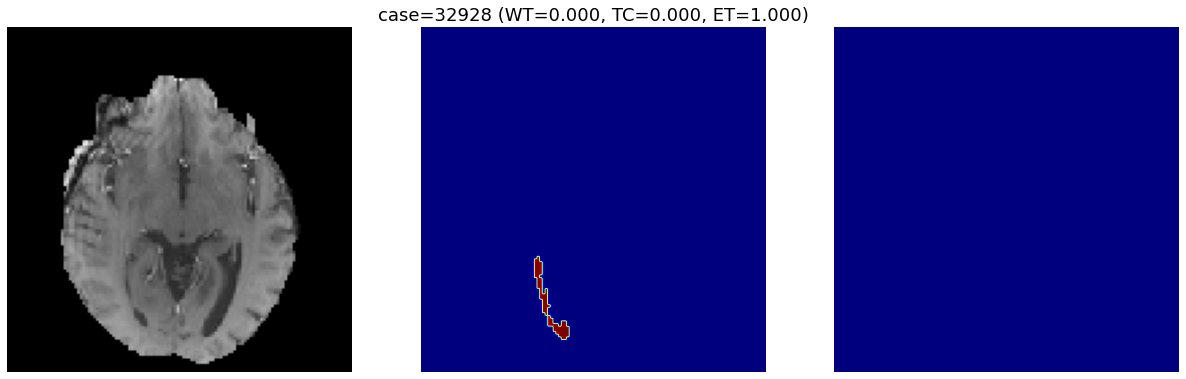

33096


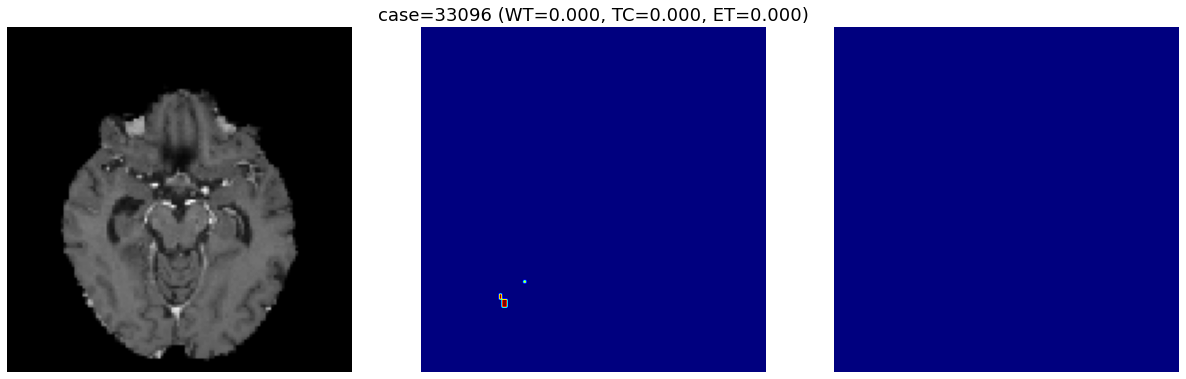

33264


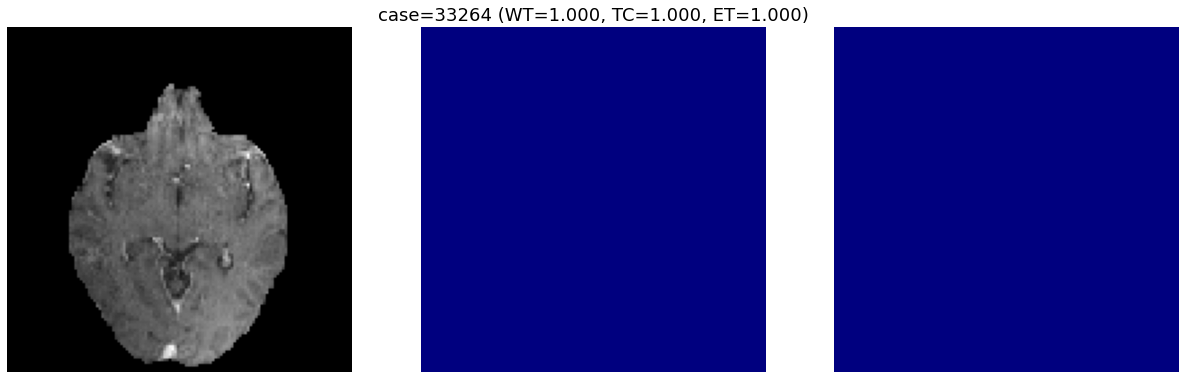

33432


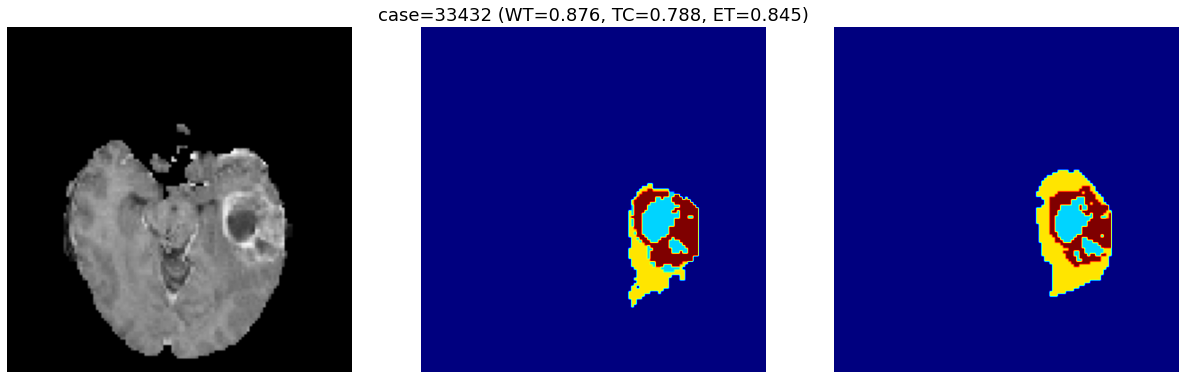

33600


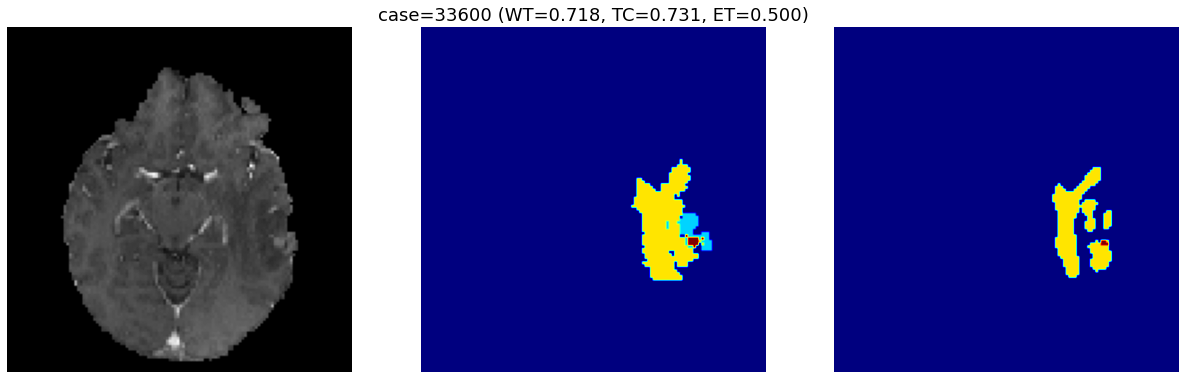

33768


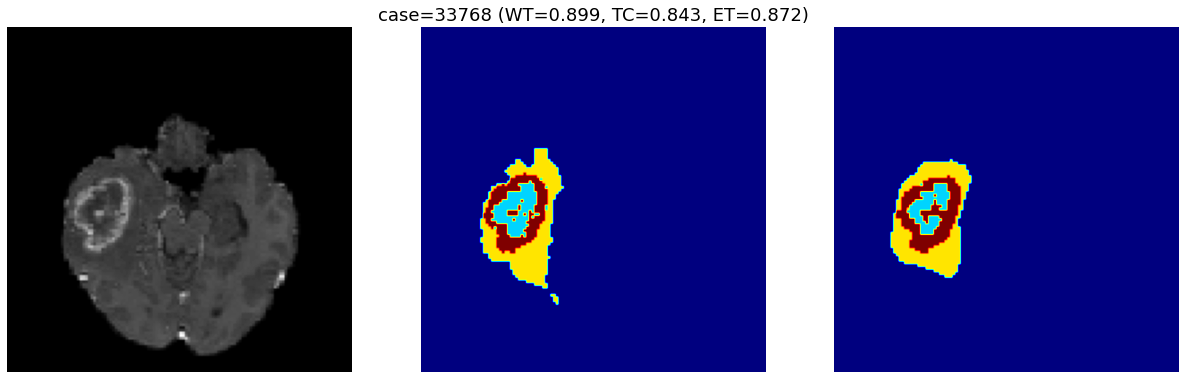

33936


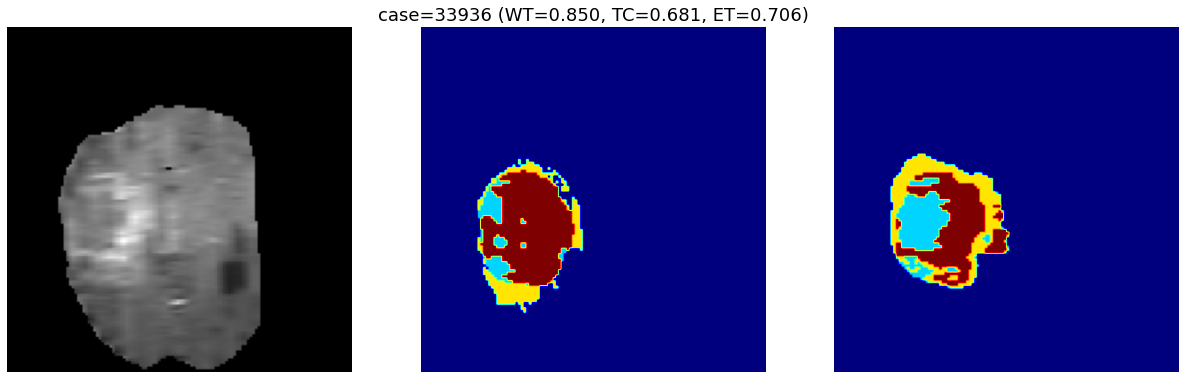

34104


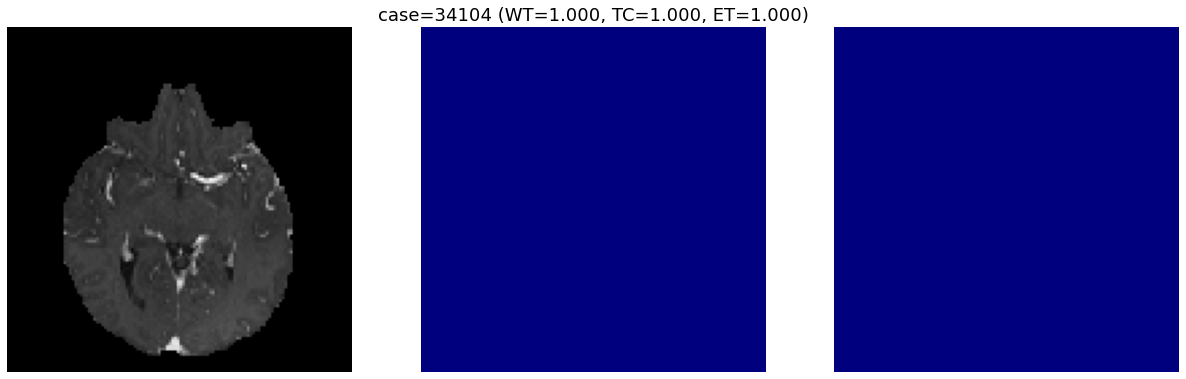

34272


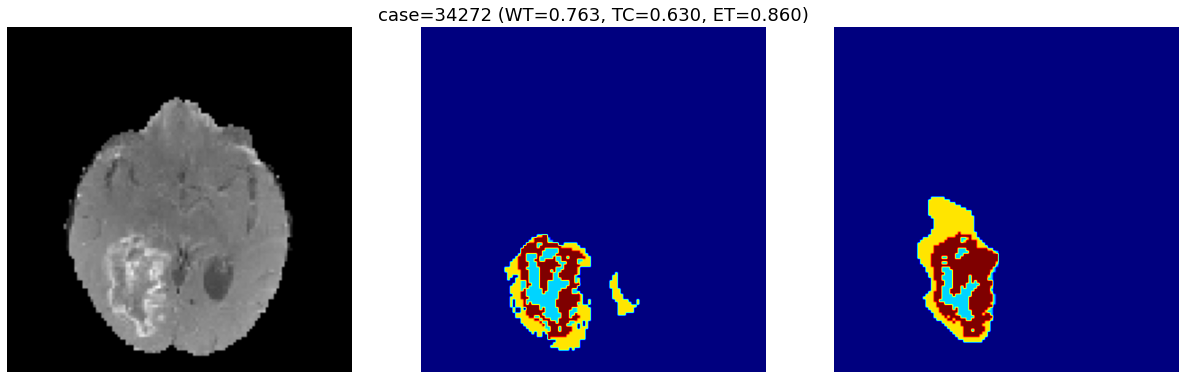

34440


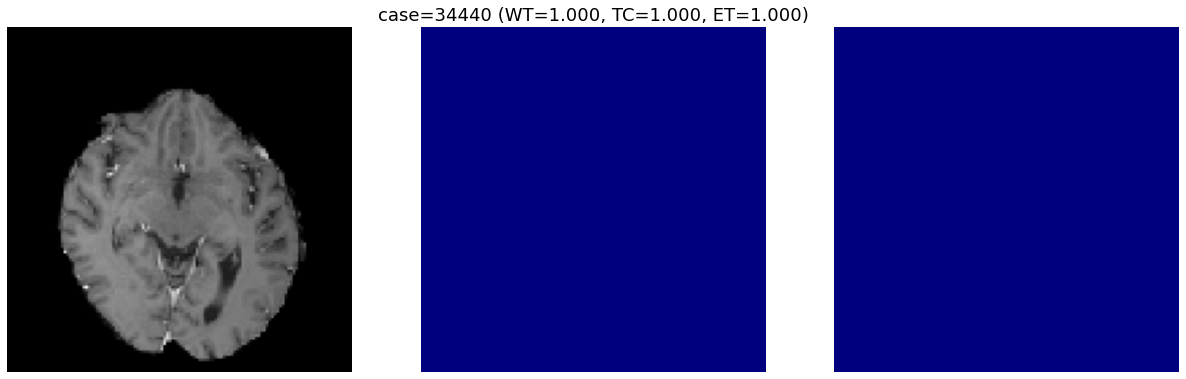

34608


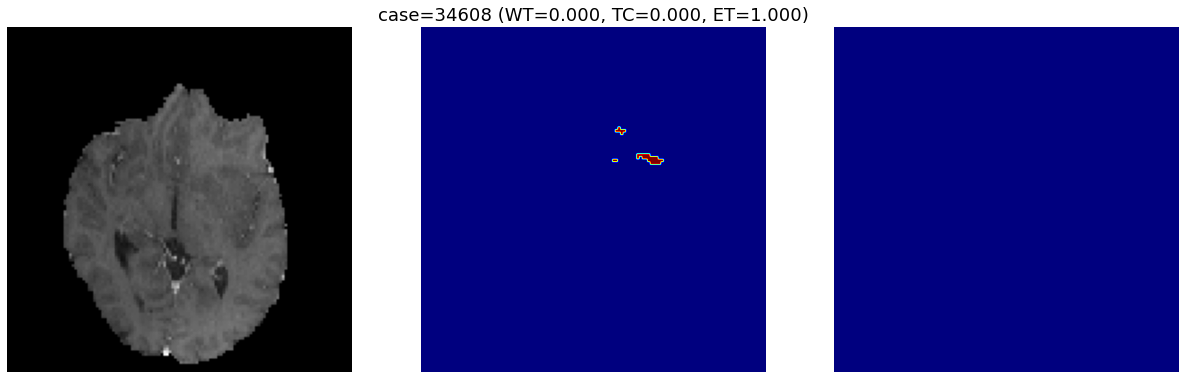

34776


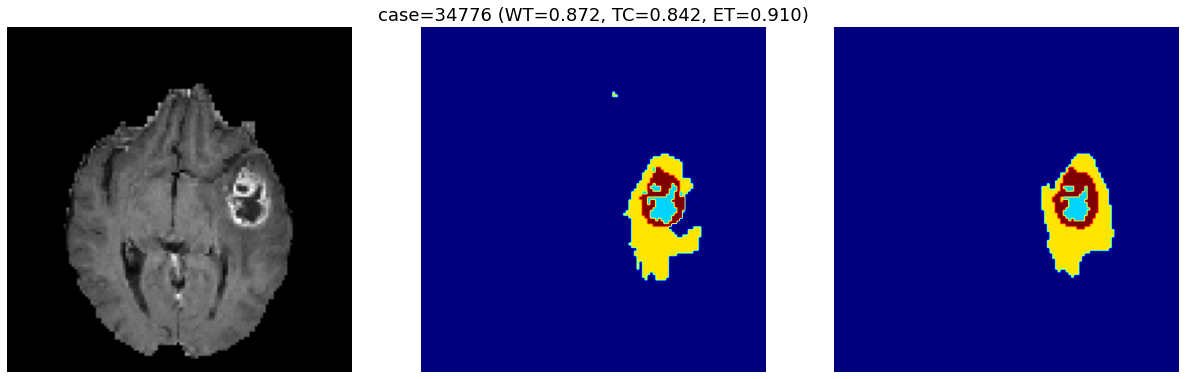

34944


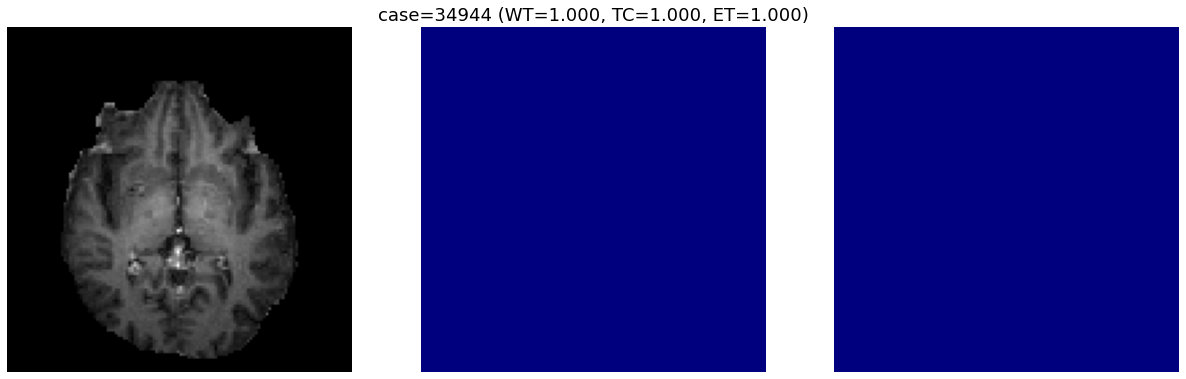

35112


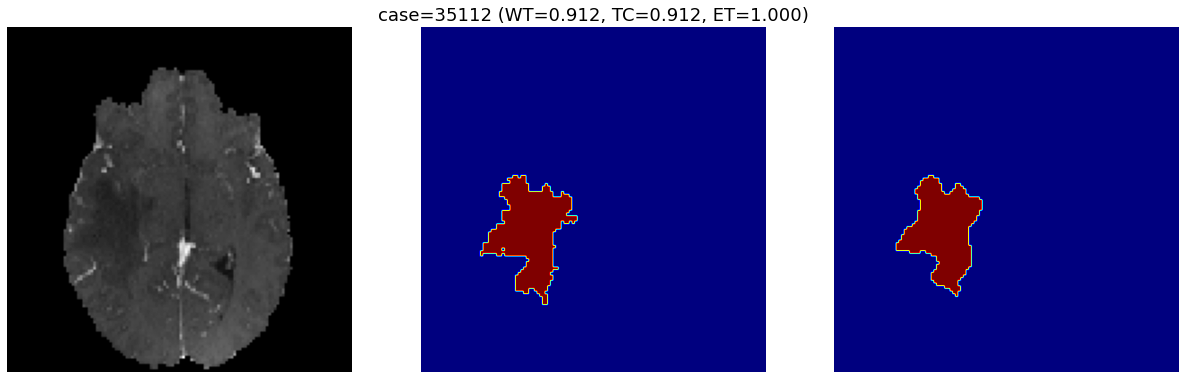

In [7]:
# def visualize_side(image, label, pred_label, title=''):
def visualize_side(image, pred_label, title=''):
    plt.figure(figsize=(21,7))
    
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(pred_label, cmap='jet')
    plt.axis('off')
    
    plt.show()

    
for i in range(0, len(test_ids), 20):
    id = test_ids[i]
    print(id)
    
    fill_id = str(id).zfill(5)
    
    image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TEST_IMAGES, f"BraTS-GLI-{str(id).zfill(5)}-000_0000.nii.gz"), sitk.sitkFloat32)).squeeze()
    # label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TEST_LABELS, f"BRATS_{fill_id}.nii.gz"), sitk.sitkFloat32)).squeeze()
    pred_label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PRED_LABELS, f"BraTS-GLI-{fill_id}-000.nii.gz"), sitk.sitkFloat32)).squeeze()
    
    metrics = test_summary_df[test_summary_df['name']==f'BRATS_{fill_id}.nii.gz']
    m = metrics.values[0][1:].astype(np.float32)
#     m[np.isnan(m)] = 1
    title = f'case={id} (dc_WT={m[0]:.3f}, dc_TC={m[1]:.3f}, dc_ET={m[2]:.3f}, hd95_WT={m[0]:.3f}, hd95_TC={m[1]:.3f}, hd95_ET={m[2]:.3f})'
    title = f'case={id} (WT={m[0]:.3f}, TC={m[1]:.3f}, ET={m[2]:.3f})'

    visualize_side(image, label, pred_label, title)